In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import register_keras_serializable
import glob
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Configuration
IMG_SIZE = (256,256)
BATCH_SIZE = 8         # Batch size
NUM_CLASSES = 34       # Number of classes (e.g., Cityscapes has 29 classes)
EPOCHS = 50            # Training epochs

In [ ]:
@register_keras_serializable()
# Channel Attention Module
class ChannelAttention(layers.Layer):
    def __init__(self, filters, reduction_ratio=8):
        super().__init__()
        self.filters = filters
        self.reduction_ratio = reduction_ratio
        
        # Global Average Pooling
        self.gap = layers.GlobalAveragePooling2D()
        
        # Fully Connected Layers
        self.fc1 = layers.Dense(filters // reduction_ratio, activation='relu')
        self.fc2 = layers.Dense(filters, activation='sigmoid')
    
    def call(self, inputs):
        # Global Average Pooling
        x = self.gap(inputs)
        
        # Channel-wise attention
        x = self.fc1(x)
        x = self.fc2(x)
        
        # Reshape for broadcasting
        x = tf.reshape(x, [-1, 1, 1, self.filters])
        
        # Apply attention
        return inputs * x

In [ ]:
@register_keras_serializable()
# Spatial Attention Module
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = layers.Conv2D(1, kernel_size, padding='same', activation='sigmoid')
        
    def call(self, inputs):
        # Aggregate channel information
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        x = tf.concat([avg_pool, max_pool], axis=-1)
        
        # Generate spatial attention map
        x = self.conv(x)
        return inputs * x

In [ ]:
# --------------------- Hybrid ConvNeXt Blocks ---------------------
@register_keras_serializable()
class ConvNeXtBlock(layers.Layer):
    def __init__(self, filters, dilation=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.dilation = dilation
        
        # Depthwise convolution
        self.dw_conv = layers.DepthwiseConv2D(7, padding='same', dilation_rate=dilation)
        self.ln = layers.LayerNormalization(epsilon=1e-6)
        
        # Pointwise convolutions
        self.pw_conv1 = layers.Conv2D(4 * filters, 1, activation='gelu')
        self.pw_conv2 = layers.Conv2D(filters, 1)  # Output matches input filters
        
        # Attention modules
        self.spatial_att = SpatialAttention(filters)
        self.channel_att = ChannelAttention(filters)
        
        # Projection for residual connection (if needed)
        self.residual_proj = layers.Conv2D(filters, 1) if filters != 192 else lambda x: x

    def call(self, inputs):
        # Depthwise convolution
        x = self.dw_conv(inputs)
        x = self.ln(x)
        
        # Pointwise convolutions
        x = self.pw_conv1(x)
        x = self.pw_conv2(x)  # Output shape: (batch, height, width, filters)
        
        # Attention modules
        spatial = self.spatial_att(x)
        channel = self.channel_att(x)
        x = spatial + channel  # Output shape: (batch, height, width, filters)
        
        # Residual connection
        residual = self.residual_proj(inputs) if self.residual_proj else inputs
        return residual + x

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'dilation': self.dilation})
        return config

def ConvNeXtDualAttention(input_shape=(512, 1024, 3), num_classes=19):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(96, 4, strides=4, padding='same')(inputs)
    x = ConvNeXtBlock(96)(x)
    x = ConvNeXtBlock(96)(x)
    skip1 = x
    
    x = layers.Conv2D(192, 2, strides=2, padding='same')(x)
    x = ConvNeXtBlock(192)(x)
    x = ConvNeXtBlock(192)(x)
    skip2 = x
    
    x = layers.Conv2D(384, 2, strides=2, padding='same')(x)
    x = ConvNeXtBlock(384)(x)
    x = ConvNeXtBlock(384)(x)
    skip3 = x
    
    # Bottleneck
    x = layers.Conv2D(768, 2, strides=2, padding='same')(x)
    x = ConvNeXtBlock(768)(x)
    x = ConvNeXtBlock(768)(x)
    x = ConvNeXtBlock(768)(x)

    # Decoder
    x = layers.Conv2DTranspose(384, 2, strides=2)(x)
    x = layers.Concatenate()([x, skip3])
    x = layers.Conv2D(384, 1)(x)
    x = ConvNeXtBlock(384)(x)
    
    x = layers.Conv2DTranspose(192, 2, strides=2)(x)
    x = layers.Concatenate()([x, skip2])
    x = layers.Conv2D(192, 1)(x)
    x = ConvNeXtBlock(192)(x)
    
    x = layers.Conv2DTranspose(96, 2, strides=2)(x)
    x = layers.Concatenate()([x, skip1])
    x = layers.Conv2D(96, 1)(x)
    x = ConvNeXtBlock(96)(x)
    
    # Final
    x = layers.Conv2DTranspose(48, 4, strides=4)(x)
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)
    
    return Model(inputs, outputs)

In [20]:
# Data Preprocessing
def preprocess_data(image_path, mask_path):
    # Load and resize image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    
    # Load and resize mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Grayscale mask
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.squeeze(mask, axis=-1)  # Remove channel dimension
    mask = tf.cast(mask, tf.int32)    # Convert to integer class indices
    
    return image, mask

# Dataset Creation
def create_dataset(image_paths, mask_paths, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:

# Dataset preparation
img = glob.glob('../input/cityscapes/Cityspaces/images/train/*/*.png')
label = glob.glob('../input/cityscapes/Cityspaces/gtFine/train/*/*_gtFine_labelIds.png')

img = sorted(img)
label = sorted(label)

# Debug: Check dataset sizes
print(f"Number of images: {len(img)}")
print(f"Number of labels: {len(label)}")

# Create matching image-label pairs
paired = [(i, l) for i, l in zip(img, label) 
          if i.split('/')[-1].split('_leftImg8bit')[0] == l.split('/')[-1].split('_gtFine_labelIds')[0]]

img, label = zip(*paired)

img = list(img)
label = list(label)


# Create datasets
train_ds = create_dataset(img, label, shuffle=True)

# Dataset preparation
val_img = glob.glob('../input/cityscapes/Cityspaces/images/val/*/*.png')
val_label = glob.glob('../input/cityscapes/Cityspaces/gtFine/val/*/*_gtFine_labelIds.png')

val_img = sorted(val_img)
val_label = sorted(val_label)

# Debug: Check dataset sizes
print(f"Number of images: {len(val_img)}")
print(f"Number of labels: {len(val_label)}")

# Create matching image-label pairs
paired = [(i, l) for i, l in zip(img, label) 
          if i.split('/')[-1].split('_leftImg8bit')[0] == l.split('/')[-1].split('_gtFine_labelIds')[0]]

val_img, val_label = zip(*paired)

val_img = list(val_img)
val_label = list(val_label)


val_ds = create_dataset(val_img, val_label)

# Debug: Test dataset creation
for images, masks in train_ds.take(1):
    print("Train batch - Images shape:", images.shape)
    print("Train batch - Masks shape:", masks.shape)

Number of images: 2975
Number of labels: 2975
Number of images: 500
Number of labels: 500
Train batch - Images shape: (8, 256, 256, 3)
Train batch - Masks shape: (8, 256, 256)


In [ ]:
# Metrics
class MeanIoU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# Compile Model
model = ConvNeXtDualAttention()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        MeanIoU(NUM_CLASSES, name='miou')
    ]
)

# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_miou',
        mode='max'
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=10,
        monitor='val_miou',
        mode='max',
        restore_best_weights=True
    )
]

# Train Model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 251s 569ms/step - accuracy: 0.4787 - loss: 1.9218 - miou: 0.0552 - val_accuracy: 0.7238 - val_loss: 1.0028 - val_miou: 0.1360
Epoch 2/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 172s 464ms/step - accuracy: 0.7385 - loss: 0.9474 - miou: 0.1586 - val_accuracy: 0.7701 - val_loss: 0.8368 - val_miou: 0.1739
Epoch 3/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 171s 461ms/step - accuracy: 0.7805 - loss: 0.7995 - miou: 0.1925 - val_accuracy: 0.7858 - val_loss: 0.7766 - val_miou: 0.1863
Epoch 4/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 172s 462ms/step - accuracy: 0.7922 - loss: 0.7566 - miou: 0.2009 - val_accuracy: 0.8025 - val_loss: 0.7170 - val_miou: 0.2015
Epoch 5/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 172s 461ms/step - accuracy: 0.8069 - loss: 0.7009 - miou: 0.2145 - val_accuracy: 0.8116 - val_loss: 0.6843 - val_miou: 0.2058
Epoch 6/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 172s 461ms/step - accuracy: 0.8163 - loss: 0.6671 - miou: 0.2249 - val_accuracy: 0.8265 - val_loss: 0.6230 - val_miou: 0.2206
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


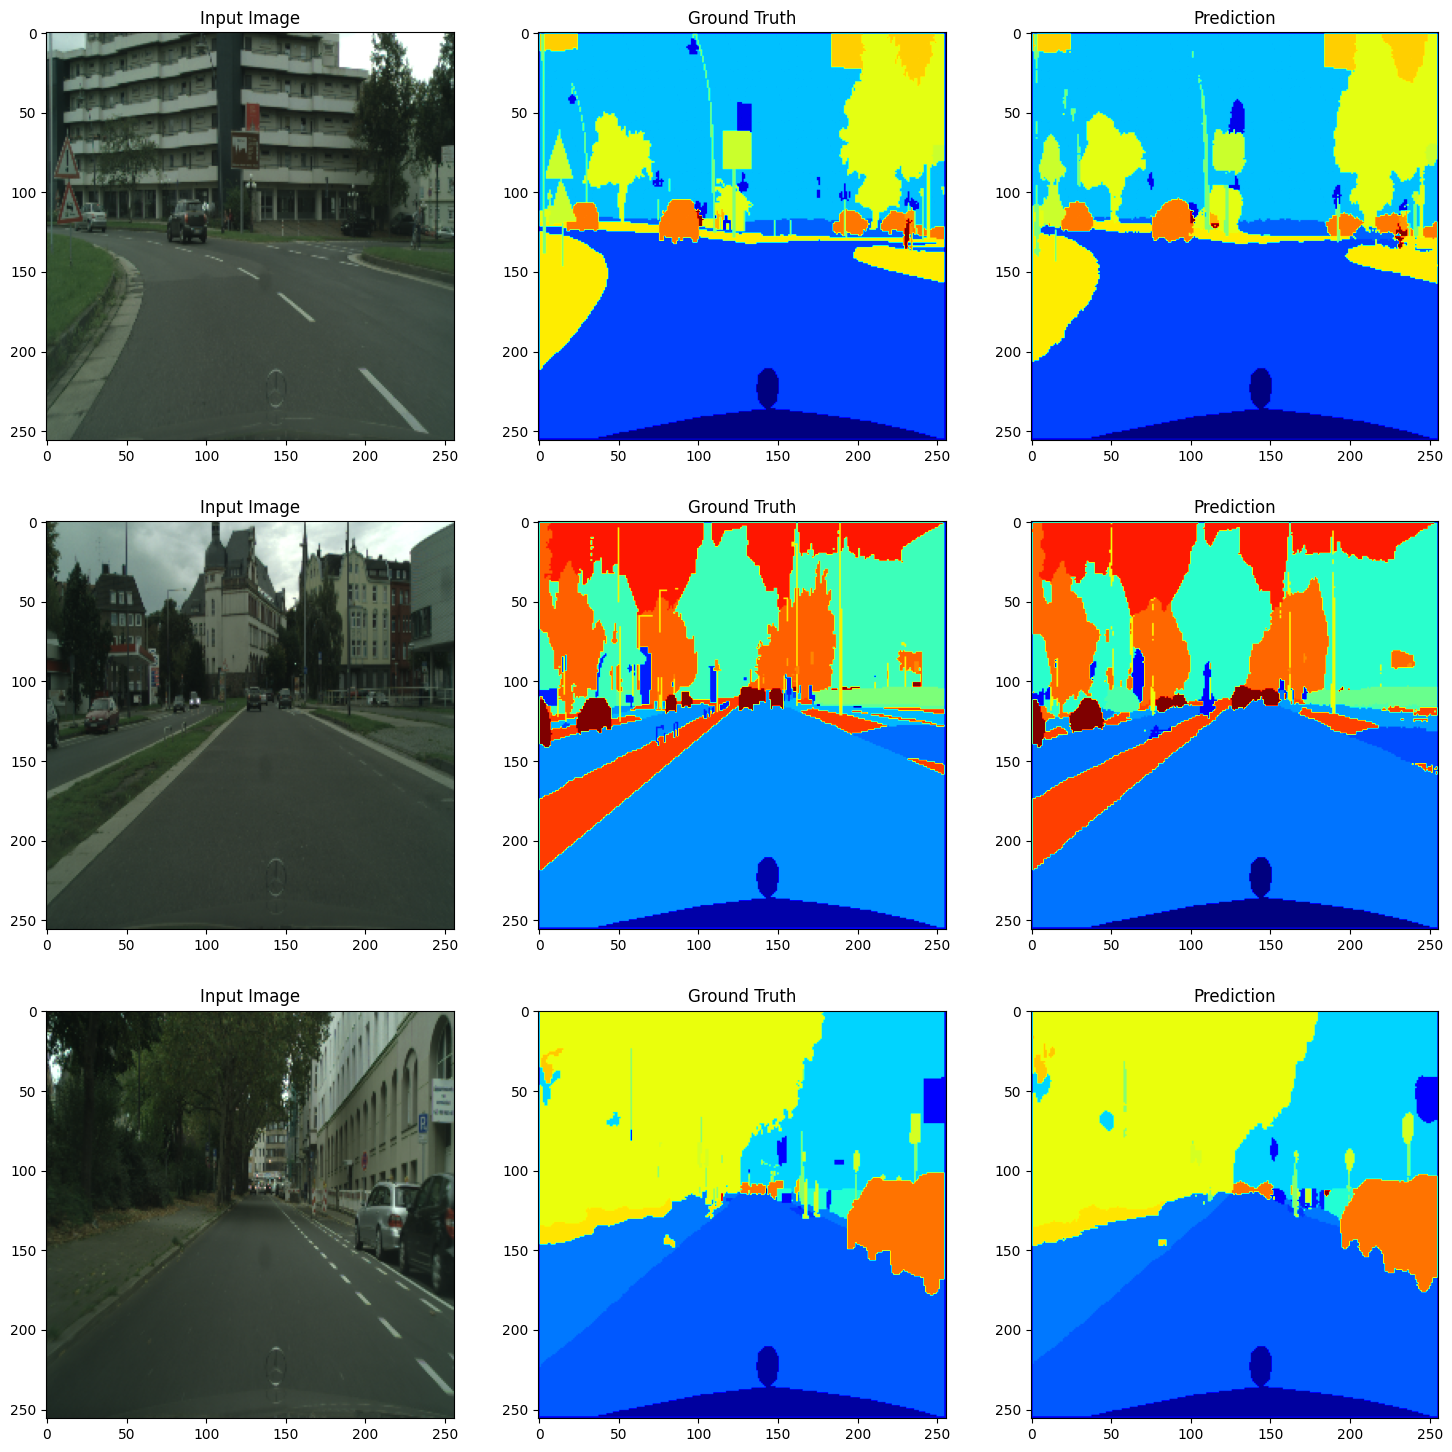

In [23]:
# Visualization
def visualize_predictions(dataset, model, num_samples=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        preds = tf.argmax(preds, axis=-1)
        
        plt.figure(figsize=(18, 6 * num_samples))
        for i in range(num_samples):
            plt.subplot(num_samples, 3, i * 3 + 1)
            plt.imshow(images[i])
            plt.title('Input Image')
            
            plt.subplot(num_samples, 3, i * 3 + 2)
            plt.imshow(masks[i], cmap='jet')
            plt.title('Ground Truth')
            
            plt.subplot(num_samples, 3, i * 3 + 3)
            plt.imshow(preds[i], cmap='jet')
            plt.title('Prediction')
        plt.show()

# Visualize predictions
visualize_predictions(val_ds, model)

In [24]:
model.save('ConvNext_Channel.keras')